In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# --- Environment Setup ---y

# Option 1: Using Anaconda
# conda create --name tf python=3.10 anaconda 
# conda activate tf
# pip install -r ../requirements.txt
# Note: This installs an older version of TensorFlow since Anaconda 
# no longer maintains recent GPU packages. It still works reliably.

# Option 2: Using Python venv
# python3 -m venv .venv
# source .venv/bin/activate
# pip install -r ../requirements.txt

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import utils as np_utils
from fMRINet import fmriNet8, fmriNet16, fmriNet32


import sklearn
import tensorflow as tf

# TensorFlow optimizers
from tensorflow.keras.optimizers import AdamW


# # AdamW lives in different places depending on TF version.
# try:
#     # TF ≥ 2.13
#     from tensorflow.keras.optimizers import AdamW
# except ImportError:
#     try:
#         # TF 2.11–2.12
#         from tensorflow.keras.optimizers.experimental import AdamW
#     except ImportError:
#         # TF 2.10.x (requires tensorflow-addons)
#         from tensorflow_addons.optimizers import AdamW

# For compatibility with libraries such as iNNvestigate, 
# you may need to disable eager execution:
# tf.compat.v1.disable_eager_execution()

In [2]:
# Load the DataFrame from the pickle file /-/ this is the toy dataframe ; for the actual data; please consider dataframe.pkl and get in touch with the author.


#{'PVT': 0, 'VWM': 1, 'DOT': 2, 'MOD': 3, 'DYN': 4, 'rest': 5}
df = pd.read_pickle('dataframe.pkl')

# df.head()


# #{'PVT': 0, 'VWM': 1, 'DOT': 2, 'MOD': 3, 'DYN': 4, 'rest': 5}
# df = pd.read_pickle('dataframe.pkl')

df.head()

,Task,Time_Series_Data,subject,session
0,0,"[[1.9457951942054184, 2.1243432446451473, 2.24...",2755j,4
1,0,"[[2.0062126993459035, 1.1112578943817553, 2.87...",2755j,4
3,1,"[[3.1558751679308363, 1.7991844301841418, 2.59...",1043f,3
5,1,"[[1.779440351375669, 1.7387005028929754, 2.338...",4558a,1
7,2,"[[0.11108687476175652, 1.7908513499100132, 0.4...",4662a,8


In [3]:
print("TF version:", tf.__version__)
print("Built with CUDA?", tf.test.is_built_with_cuda())
print("Visible GPUs:", tf.config.list_physical_devices("GPU"))

TF version: 2.19.1
Built with CUDA? False
Visible GPUs: []


In [4]:
# subjs = df["subject"].unique()
# np.random.shuffle(subjs) # do in-place shuffle

# to work with the same train/validation splits while doing model development
with open('subjs.pickle', 'rb') as f:
    subjs = pickle.load(f)

# pull train/valid data by taking subjects from shuffled list
train_df = df[df['subject'].isin(subjs[0:45])]
valid_df = df[df['subject'].isin(subjs[45:,])]

# convert to numpy arrays and do reordering of data dimensions to feed into network
train_label = np.array(train_df['Task'])

train_data  = np.dstack(train_df['Time_Series_Data'])
train_data  = np.expand_dims(train_data, axis=0)
train_data  = np.transpose(train_data, axes=[3, 2, 1, 0]) # (batch, row, time, region)

valid_label = np.array(valid_df['Task'])

valid_data  = np.dstack(valid_df['Time_Series_Data'])
valid_data  = np.expand_dims(valid_data, axis=0)
valid_data  = np.transpose(valid_data, axes=[3, 2, 1, 0]) # (batch, row, time, region)

In [5]:
train_label = np_utils.to_categorical(train_label)
valid_label = np_utils.to_categorical(valid_label)


In [6]:
np.save('valid_data.npy', valid_data)
np.save('valid_label.npy', valid_label)

print(f"Validation data shape: {valid_data.shape}")
print(f"Validation label shape: {valid_label.shape}")
print("Files saved successfully:")
print("- valid_data.npy")
print("- valid_label.npy")

Validation data shape: (639, 214, 277, 1)
Validation label shape: (639, 6)
Files saved successfully:
- valid_data.npy
- valid_label.npy


In [6]:
# calculate class weights for training data to use at training time
train_label_v2 = np.argmax(train_label, axis=1)
a, b           = np.unique(train_label_v2, return_counts=True)
weights        = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=a, y=train_label_v2)
class_weights  = {0:weights[0], 1:weights[1], 2:weights[2], 3:weights[3], 4:weights[4], 5:weights[5]}
class_weights

{0: np.float64(1.3031135531135531),
 1: np.float64(0.8800247371675943),
 2: np.float64(1.2417102966841187),
 3: np.float64(0.9139370584457289),
 4: np.float64(0.568063872255489),
 5: np.float64(2.2914653784219)}

In [7]:
model = fmriNet8(num_classes=6, input_shape=(214, 277, 1), temporal_kernel_sec=60, fs=1.0)  # or fmriNet16(), fmriNet32()

model.summary()

Model: "fmriNet8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 214, 277, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 214, 277, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 214, 277, 8)    │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 277, 214, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 277, 1, 32)     │         6,848 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 277, 1, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 277, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 1, 277, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 18, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 18, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 18, 64)      │         2,304 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 18, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 4, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,558 (45.15 KB)

 Trainable params: 11,366 (44.40 KB)

 Non-trainable params: 192 (768.00 B)

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=AdamW(weight_decay=0.0005), 
              metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

# simple learning rate schedule, half learning rate every 200 epochs
# which seems to do ok for this data
def lr_schedule(epoch):
         return (0.001 * np.power(0.5, np.floor(epoch/200)))

scheduler    = LearningRateScheduler(lr_schedule, verbose=1)

In [11]:
# without eager execution this takes much longer to train..
fittedModel = model.fit(train_data, train_label, batch_size = 64, epochs = 400, 
                        verbose = 2, validation_data=(valid_data, valid_label),
                        callbacks=[checkpointer], class_weight = class_weights)

Epoch 1/400

Epoch 1: val_loss improved from None to 1.79390, saving model to /tmp/checkpoint.h5


45/45 - 16s - 345ms/step - accuracy: 0.1644 - loss: 2.0109 - val_accuracy: 0.1268 - val_loss: 1.7939
Epoch 2/400

Epoch 2: val_loss improved from 1.79390 to 1.79047, saving model to /tmp/checkpoint.h5


45/45 - 14s - 316ms/step - accuracy: 0.1725 - loss: 1.9497 - val_accuracy: 0.1596 - val_loss: 1.7905
Epoch 3/400

Epoch 3: val_loss improved from 1.79047 to 1.78030, saving model to /tmp/checkpoint.h5


45/45 - 14s - 315ms/step - accuracy: 0.2024 - loss: 1.8692 - val_accuracy: 0.2363 - val_loss: 1.7803
Epoch 4/400

Epoch 4: val_loss improved from 1.78030 to 1.75671, saving model to /tmp/checkpoint.h5


45/45 - 14s - 313ms/step - accuracy: 0.2347 - loss: 1.7920 - val_accuracy: 0.1987 - val_loss: 1.7567
Epoch 5/400

Epoch 5: val_loss improved from 1.75671 to 1.71669, saving model to /tmp/checkpoint.h5


45/45 - 14s - 317ms/step - accuracy: 0.2477 - loss: 1.7473 - val_accuracy: 0.2598 - val_loss: 1.7167
Epoch 6/400

Epoch 6: val_loss improved from 1.71669 to 1.65407, saving model to /tmp/checkpoint.h5


45/45 - 14s - 316ms/step - accuracy: 0.2994 - loss: 1.6656 - val_accuracy: 0.3505 - val_loss: 1.6541
Epoch 7/400

Epoch 7: val_loss improved from 1.65407 to 1.50430, saving model to /tmp/checkpoint.h5


45/45 - 14s - 318ms/step - accuracy: 0.3542 - loss: 1.5701 - val_accuracy: 0.4319 - val_loss: 1.5043
Epoch 8/400

Epoch 8: val_loss improved from 1.50430 to 1.37655, saving model to /tmp/checkpoint.h5


45/45 - 13s - 299ms/step - accuracy: 0.3840 - loss: 1.4801 - val_accuracy: 0.4710 - val_loss: 1.3766
Epoch 9/400

Epoch 9: val_loss improved from 1.37655 to 1.28456, saving model to /tmp/checkpoint.h5


45/45 - 13s - 296ms/step - accuracy: 0.3960 - loss: 1.4140 - val_accuracy: 0.5446 - val_loss: 1.2846
Epoch 10/400

Epoch 10: val_loss improved from 1.28456 to 1.24970, saving model to /tmp/checkpoint.h5


45/45 - 14s - 316ms/step - accuracy: 0.4290 - loss: 1.3612 - val_accuracy: 0.5446 - val_loss: 1.2497
Epoch 11/400

Epoch 11: val_loss improved from 1.24970 to 1.17913, saving model to /tmp/checkpoint.h5


45/45 - 14s - 303ms/step - accuracy: 0.4396 - loss: 1.3457 - val_accuracy: 0.5837 - val_loss: 1.1791
Epoch 12/400

Epoch 12: val_loss improved from 1.17913 to 1.14241, saving model to /tmp/checkpoint.h5


45/45 - 14s - 301ms/step - accuracy: 0.4649 - loss: 1.2929 - val_accuracy: 0.5603 - val_loss: 1.1424
Epoch 13/400

Epoch 13: val_loss improved from 1.14241 to 1.09747, saving model to /tmp/checkpoint.h5


45/45 - 14s - 305ms/step - accuracy: 0.4743 - loss: 1.2680 - val_accuracy: 0.6025 - val_loss: 1.0975
Epoch 14/400

Epoch 14: val_loss improved from 1.09747 to 1.06849, saving model to /tmp/checkpoint.h5


45/45 - 14s - 308ms/step - accuracy: 0.4736 - loss: 1.2359 - val_accuracy: 0.6103 - val_loss: 1.0685
Epoch 15/400

Epoch 15: val_loss improved from 1.06849 to 1.05919, saving model to /tmp/checkpoint.h5


45/45 - 13s - 291ms/step - accuracy: 0.4958 - loss: 1.2157 - val_accuracy: 0.5790 - val_loss: 1.0592
Epoch 16/400

Epoch 16: val_loss improved from 1.05919 to 1.03799, saving model to /tmp/checkpoint.h5


45/45 - 13s - 286ms/step - accuracy: 0.4877 - loss: 1.2182 - val_accuracy: 0.5962 - val_loss: 1.0380
Epoch 17/400

Epoch 17: val_loss improved from 1.03799 to 0.99926, saving model to /tmp/checkpoint.h5


45/45 - 13s - 283ms/step - accuracy: 0.5091 - loss: 1.1692 - val_accuracy: 0.6056 - val_loss: 0.9993
Epoch 18/400

Epoch 18: val_loss improved from 0.99926 to 0.99633, saving model to /tmp/checkpoint.h5


45/45 - 13s - 290ms/step - accuracy: 0.5095 - loss: 1.1966 - val_accuracy: 0.6166 - val_loss: 0.9963
Epoch 19/400

Epoch 19: val_loss improved from 0.99633 to 0.92823, saving model to /tmp/checkpoint.h5


45/45 - 13s - 290ms/step - accuracy: 0.5267 - loss: 1.1281 - val_accuracy: 0.6808 - val_loss: 0.9282
Epoch 20/400

Epoch 20: val_loss improved from 0.92823 to 0.91322, saving model to /tmp/checkpoint.h5


45/45 - 14s - 314ms/step - accuracy: 0.5499 - loss: 1.1163 - val_accuracy: 0.6745 - val_loss: 0.9132
Epoch 21/400

Epoch 21: val_loss improved from 0.91322 to 0.90153, saving model to /tmp/checkpoint.h5


45/45 - 13s - 287ms/step - accuracy: 0.5404 - loss: 1.1070 - val_accuracy: 0.6792 - val_loss: 0.9015
Epoch 22/400

Epoch 22: val_loss did not improve from 0.90153
45/45 - 13s - 286ms/step - accuracy: 0.5394 - loss: 1.0858 - val_accuracy: 0.6808 - val_loss: 0.9023
Epoch 23/400

Epoch 23: val_loss improved from 0.90153 to 0.89126, saving model to /tmp/checkpoint.h5


45/45 - 13s - 288ms/step - accuracy: 0.5485 - loss: 1.0827 - val_accuracy: 0.6948 - val_loss: 0.8913
Epoch 24/400

Epoch 24: val_loss did not improve from 0.89126
45/45 - 13s - 286ms/step - accuracy: 0.5555 - loss: 1.0697 - val_accuracy: 0.6917 - val_loss: 0.8919
Epoch 25/400

Epoch 25: val_loss improved from 0.89126 to 0.86650, saving model to /tmp/checkpoint.h5


45/45 - 13s - 288ms/step - accuracy: 0.5548 - loss: 1.0788 - val_accuracy: 0.6729 - val_loss: 0.8665
Epoch 26/400

Epoch 26: val_loss improved from 0.86650 to 0.86019, saving model to /tmp/checkpoint.h5


45/45 - 13s - 285ms/step - accuracy: 0.5625 - loss: 1.0565 - val_accuracy: 0.6995 - val_loss: 0.8602
Epoch 27/400

Epoch 27: val_loss did not improve from 0.86019
45/45 - 13s - 291ms/step - accuracy: 0.5636 - loss: 1.0616 - val_accuracy: 0.6995 - val_loss: 0.8722
Epoch 28/400

Epoch 28: val_loss did not improve from 0.86019
45/45 - 13s - 288ms/step - accuracy: 0.5594 - loss: 1.0598 - val_accuracy: 0.6980 - val_loss: 0.8634
Epoch 29/400

Epoch 29: val_loss improved from 0.86019 to 0.84778, saving model to /tmp/checkpoint.h5


45/45 - 13s - 289ms/step - accuracy: 0.5661 - loss: 1.0490 - val_accuracy: 0.7152 - val_loss: 0.8478
Epoch 30/400

Epoch 30: val_loss did not improve from 0.84778
45/45 - 13s - 288ms/step - accuracy: 0.5791 - loss: 1.0210 - val_accuracy: 0.6917 - val_loss: 0.8489
Epoch 31/400

Epoch 31: val_loss improved from 0.84778 to 0.83147, saving model to /tmp/checkpoint.h5


45/45 - 13s - 291ms/step - accuracy: 0.5857 - loss: 1.0204 - val_accuracy: 0.7230 - val_loss: 0.8315
Epoch 32/400

Epoch 32: val_loss improved from 0.83147 to 0.81939, saving model to /tmp/checkpoint.h5


45/45 - 13s - 287ms/step - accuracy: 0.5798 - loss: 1.0583 - val_accuracy: 0.7324 - val_loss: 0.8194
Epoch 33/400

Epoch 33: val_loss did not improve from 0.81939
45/45 - 13s - 285ms/step - accuracy: 0.5889 - loss: 1.0174 - val_accuracy: 0.7230 - val_loss: 0.8200
Epoch 34/400

Epoch 34: val_loss improved from 0.81939 to 0.81480, saving model to /tmp/checkpoint.h5


45/45 - 13s - 291ms/step - accuracy: 0.5889 - loss: 1.0039 - val_accuracy: 0.7355 - val_loss: 0.8148
Epoch 35/400

Epoch 35: val_loss improved from 0.81480 to 0.80939, saving model to /tmp/checkpoint.h5


45/45 - 13s - 289ms/step - accuracy: 0.5857 - loss: 1.0088 - val_accuracy: 0.7199 - val_loss: 0.8094
Epoch 36/400

Epoch 36: val_loss improved from 0.80939 to 0.78721, saving model to /tmp/checkpoint.h5


45/45 - 13s - 291ms/step - accuracy: 0.5935 - loss: 0.9846 - val_accuracy: 0.7480 - val_loss: 0.7872
Epoch 37/400

Epoch 37: val_loss improved from 0.78721 to 0.77259, saving model to /tmp/checkpoint.h5


45/45 - 13s - 290ms/step - accuracy: 0.6033 - loss: 1.0007 - val_accuracy: 0.7402 - val_loss: 0.7726
Epoch 38/400

Epoch 38: val_loss improved from 0.77259 to 0.75999, saving model to /tmp/checkpoint.h5


45/45 - 13s - 288ms/step - accuracy: 0.6181 - loss: 0.9701 - val_accuracy: 0.7574 - val_loss: 0.7600
Epoch 39/400

Epoch 39: val_loss improved from 0.75999 to 0.75883, saving model to /tmp/checkpoint.h5


45/45 - 14s - 307ms/step - accuracy: 0.6096 - loss: 0.9683 - val_accuracy: 0.7449 - val_loss: 0.7588
Epoch 40/400

Epoch 40: val_loss improved from 0.75883 to 0.75635, saving model to /tmp/checkpoint.h5


45/45 - 14s - 307ms/step - accuracy: 0.6188 - loss: 0.9661 - val_accuracy: 0.7668 - val_loss: 0.7563
Epoch 41/400

Epoch 41: val_loss improved from 0.75635 to 0.74028, saving model to /tmp/checkpoint.h5


45/45 - 14s - 310ms/step - accuracy: 0.6117 - loss: 0.9616 - val_accuracy: 0.7778 - val_loss: 0.7403
Epoch 42/400

Epoch 42: val_loss did not improve from 0.74028
45/45 - 14s - 303ms/step - accuracy: 0.6198 - loss: 0.9626 - val_accuracy: 0.7512 - val_loss: 0.7479
Epoch 43/400

Epoch 43: val_loss did not improve from 0.74028
45/45 - 15s - 332ms/step - accuracy: 0.6275 - loss: 0.9428 - val_accuracy: 0.7621 - val_loss: 0.7406
Epoch 44/400

Epoch 44: val_loss improved from 0.74028 to 0.71619, saving model to /tmp/checkpoint.h5


45/45 - 15s - 340ms/step - accuracy: 0.6181 - loss: 0.9522 - val_accuracy: 0.7793 - val_loss: 0.7162
Epoch 45/400

Epoch 45: val_loss did not improve from 0.71619
45/45 - 15s - 342ms/step - accuracy: 0.6314 - loss: 0.9539 - val_accuracy: 0.7621 - val_loss: 0.7320
Epoch 46/400

Epoch 46: val_loss improved from 0.71619 to 0.70926, saving model to /tmp/checkpoint.h5


45/45 - 15s - 341ms/step - accuracy: 0.6261 - loss: 0.9645 - val_accuracy: 0.7700 - val_loss: 0.7093
Epoch 47/400

Epoch 47: val_loss did not improve from 0.70926
45/45 - 15s - 341ms/step - accuracy: 0.6216 - loss: 0.9287 - val_accuracy: 0.7684 - val_loss: 0.7104
Epoch 48/400

Epoch 48: val_loss improved from 0.70926 to 0.70698, saving model to /tmp/checkpoint.h5


45/45 - 15s - 336ms/step - accuracy: 0.6293 - loss: 0.9359 - val_accuracy: 0.7606 - val_loss: 0.7070
Epoch 49/400

Epoch 49: val_loss did not improve from 0.70698
45/45 - 15s - 335ms/step - accuracy: 0.6539 - loss: 0.8956 - val_accuracy: 0.7621 - val_loss: 0.7127
Epoch 50/400

Epoch 50: val_loss improved from 0.70698 to 0.69769, saving model to /tmp/checkpoint.h5


45/45 - 15s - 341ms/step - accuracy: 0.6434 - loss: 0.9169 - val_accuracy: 0.7700 - val_loss: 0.6977
Epoch 51/400

Epoch 51: val_loss did not improve from 0.69769
45/45 - 15s - 338ms/step - accuracy: 0.6420 - loss: 0.8861 - val_accuracy: 0.7559 - val_loss: 0.7180
Epoch 52/400

Epoch 52: val_loss did not improve from 0.69769
45/45 - 15s - 342ms/step - accuracy: 0.6507 - loss: 0.9150 - val_accuracy: 0.7543 - val_loss: 0.7066
Epoch 53/400

Epoch 53: val_loss improved from 0.69769 to 0.68612, saving model to /tmp/checkpoint.h5


45/45 - 15s - 341ms/step - accuracy: 0.6420 - loss: 0.9224 - val_accuracy: 0.7762 - val_loss: 0.6861
Epoch 54/400

Epoch 54: val_loss did not improve from 0.68612
45/45 - 15s - 338ms/step - accuracy: 0.6455 - loss: 0.9207 - val_accuracy: 0.7637 - val_loss: 0.6945
Epoch 55/400

Epoch 55: val_loss improved from 0.68612 to 0.68351, saving model to /tmp/checkpoint.h5


45/45 - 15s - 342ms/step - accuracy: 0.6532 - loss: 0.8950 - val_accuracy: 0.7684 - val_loss: 0.6835
Epoch 56/400

Epoch 56: val_loss improved from 0.68351 to 0.68002, saving model to /tmp/checkpoint.h5


45/45 - 15s - 341ms/step - accuracy: 0.6409 - loss: 0.9014 - val_accuracy: 0.7762 - val_loss: 0.6800
Epoch 57/400

Epoch 57: val_loss improved from 0.68002 to 0.66098, saving model to /tmp/checkpoint.h5


45/45 - 16s - 347ms/step - accuracy: 0.6413 - loss: 0.9107 - val_accuracy: 0.7793 - val_loss: 0.6610
Epoch 58/400

Epoch 58: val_loss did not improve from 0.66098
45/45 - 15s - 340ms/step - accuracy: 0.6539 - loss: 0.9124 - val_accuracy: 0.7903 - val_loss: 0.6643
Epoch 59/400

Epoch 59: val_loss did not improve from 0.66098
45/45 - 15s - 341ms/step - accuracy: 0.6423 - loss: 0.9080 - val_accuracy: 0.7746 - val_loss: 0.6724
Epoch 60/400

Epoch 60: val_loss did not improve from 0.66098
45/45 - 16s - 351ms/step - accuracy: 0.6599 - loss: 0.8887 - val_accuracy: 0.7574 - val_loss: 0.6978
Epoch 61/400

Epoch 61: val_loss did not improve from 0.66098
45/45 - 15s - 344ms/step - accuracy: 0.6637 - loss: 0.8771 - val_accuracy: 0.7825 - val_loss: 0.6809
Epoch 62/400

Epoch 62: val_loss did not improve from 0.66098
45/45 - 15s - 342ms/step - accuracy: 0.6476 - loss: 0.9004 - val_accuracy: 0.7653 - val_loss: 0.6860
Epoch 63/400

Epoch 63: val_loss did not improve from 0.66098
45/45 - 15s - 341ms/st

45/45 - 15s - 344ms/step - accuracy: 0.6644 - loss: 0.8757 - val_accuracy: 0.7809 - val_loss: 0.6588
Epoch 68/400

Epoch 68: val_loss did not improve from 0.65881
45/45 - 15s - 340ms/step - accuracy: 0.6595 - loss: 0.8831 - val_accuracy: 0.7809 - val_loss: 0.6603
Epoch 69/400

Epoch 69: val_loss improved from 0.65881 to 0.65689, saving model to /tmp/checkpoint.h5


45/45 - 15s - 338ms/step - accuracy: 0.6532 - loss: 0.8707 - val_accuracy: 0.7919 - val_loss: 0.6569
Epoch 70/400

Epoch 70: val_loss did not improve from 0.65689
45/45 - 15s - 339ms/step - accuracy: 0.6560 - loss: 0.8776 - val_accuracy: 0.7919 - val_loss: 0.6603
Epoch 71/400

Epoch 71: val_loss did not improve from 0.65689
45/45 - 15s - 344ms/step - accuracy: 0.6571 - loss: 0.8655 - val_accuracy: 0.7746 - val_loss: 0.6648
Epoch 72/400

Epoch 72: val_loss did not improve from 0.65689
45/45 - 15s - 340ms/step - accuracy: 0.6848 - loss: 0.8505 - val_accuracy: 0.7778 - val_loss: 0.6703
Epoch 73/400

Epoch 73: val_loss did not improve from 0.65689
45/45 - 15s - 337ms/step - accuracy: 0.6623 - loss: 0.8733 - val_accuracy: 0.7731 - val_loss: 0.6657
Epoch 74/400

Epoch 74: val_loss did not improve from 0.65689
45/45 - 15s - 342ms/step - accuracy: 0.6651 - loss: 0.8790 - val_accuracy: 0.7512 - val_loss: 0.6799
Epoch 75/400

Epoch 75: val_loss did not improve from 0.65689
45/45 - 15s - 338ms/st

45/45 - 15s - 337ms/step - accuracy: 0.6774 - loss: 0.8337 - val_accuracy: 0.7825 - val_loss: 0.6499
Epoch 80/400

Epoch 80: val_loss did not improve from 0.64985
45/45 - 15s - 337ms/step - accuracy: 0.6641 - loss: 0.8661 - val_accuracy: 0.7778 - val_loss: 0.6544
Epoch 81/400

Epoch 81: val_loss improved from 0.64985 to 0.64222, saving model to /tmp/checkpoint.h5


45/45 - 15s - 337ms/step - accuracy: 0.6560 - loss: 0.8543 - val_accuracy: 0.7903 - val_loss: 0.6422
Epoch 82/400

Epoch 82: val_loss did not improve from 0.64222
45/45 - 15s - 339ms/step - accuracy: 0.6560 - loss: 0.8835 - val_accuracy: 0.7731 - val_loss: 0.6645
Epoch 83/400

Epoch 83: val_loss did not improve from 0.64222
45/45 - 15s - 339ms/step - accuracy: 0.6648 - loss: 0.8515 - val_accuracy: 0.7621 - val_loss: 0.6625
Epoch 84/400

Epoch 84: val_loss did not improve from 0.64222
45/45 - 16s - 347ms/step - accuracy: 0.6680 - loss: 0.8501 - val_accuracy: 0.7762 - val_loss: 0.6642
Epoch 85/400

Epoch 85: val_loss did not improve from 0.64222
45/45 - 16s - 346ms/step - accuracy: 0.6673 - loss: 0.8637 - val_accuracy: 0.7856 - val_loss: 0.6547
Epoch 86/400

Epoch 86: val_loss improved from 0.64222 to 0.64203, saving model to /tmp/checkpoint.h5


45/45 - 16s - 348ms/step - accuracy: 0.6690 - loss: 0.8538 - val_accuracy: 0.7903 - val_loss: 0.6420
Epoch 87/400

Epoch 87: val_loss did not improve from 0.64203
45/45 - 15s - 342ms/step - accuracy: 0.6616 - loss: 0.8450 - val_accuracy: 0.7809 - val_loss: 0.6443
Epoch 88/400

Epoch 88: val_loss improved from 0.64203 to 0.63117, saving model to /tmp/checkpoint.h5


45/45 - 15s - 340ms/step - accuracy: 0.6824 - loss: 0.8390 - val_accuracy: 0.7887 - val_loss: 0.6312
Epoch 89/400

Epoch 89: val_loss did not improve from 0.63117
45/45 - 16s - 346ms/step - accuracy: 0.6711 - loss: 0.8594 - val_accuracy: 0.8044 - val_loss: 0.6390
Epoch 90/400

Epoch 90: val_loss did not improve from 0.63117
45/45 - 16s - 345ms/step - accuracy: 0.6687 - loss: 0.8567 - val_accuracy: 0.7778 - val_loss: 0.6436
Epoch 91/400

Epoch 91: val_loss did not improve from 0.63117
45/45 - 15s - 342ms/step - accuracy: 0.6676 - loss: 0.8402 - val_accuracy: 0.7746 - val_loss: 0.6646
Epoch 92/400

Epoch 92: val_loss did not improve from 0.63117
45/45 - 15s - 340ms/step - accuracy: 0.6897 - loss: 0.8362 - val_accuracy: 0.7840 - val_loss: 0.6421
Epoch 93/400

Epoch 93: val_loss did not improve from 0.63117
45/45 - 15s - 338ms/step - accuracy: 0.6680 - loss: 0.8659 - val_accuracy: 0.7793 - val_loss: 0.6531
Epoch 94/400

Epoch 94: val_loss did not improve from 0.63117
45/45 - 15s - 340ms/st

45/45 - 16s - 361ms/step - accuracy: 0.6571 - loss: 0.8552 - val_accuracy: 0.8013 - val_loss: 0.6247
Epoch 110/400

Epoch 110: val_loss did not improve from 0.62474
45/45 - 16s - 351ms/step - accuracy: 0.6718 - loss: 0.8514 - val_accuracy: 0.7887 - val_loss: 0.6456
Epoch 111/400

Epoch 111: val_loss did not improve from 0.62474
45/45 - 16s - 351ms/step - accuracy: 0.6817 - loss: 0.8445 - val_accuracy: 0.7966 - val_loss: 0.6298
Epoch 112/400

Epoch 112: val_loss did not improve from 0.62474
45/45 - 16s - 355ms/step - accuracy: 0.6757 - loss: 0.8361 - val_accuracy: 0.8044 - val_loss: 0.6282
Epoch 113/400

Epoch 113: val_loss did not improve from 0.62474
45/45 - 16s - 354ms/step - accuracy: 0.6799 - loss: 0.8377 - val_accuracy: 0.7997 - val_loss: 0.6364
Epoch 114/400

Epoch 114: val_loss did not improve from 0.62474
45/45 - 16s - 346ms/step - accuracy: 0.6567 - loss: 0.8537 - val_accuracy: 0.7856 - val_loss: 0.6331
Epoch 115/400

Epoch 115: val_loss did not improve from 0.62474
45/45 - 16

45/45 - 16s - 349ms/step - accuracy: 0.6736 - loss: 0.8294 - val_accuracy: 0.7950 - val_loss: 0.6246
Epoch 120/400

Epoch 120: val_loss did not improve from 0.62465
45/45 - 16s - 355ms/step - accuracy: 0.6673 - loss: 0.8302 - val_accuracy: 0.7778 - val_loss: 0.6288
Epoch 121/400

Epoch 121: val_loss did not improve from 0.62465
45/45 - 16s - 348ms/step - accuracy: 0.6644 - loss: 0.8476 - val_accuracy: 0.7997 - val_loss: 0.6306
Epoch 122/400

Epoch 122: val_loss did not improve from 0.62465
45/45 - 16s - 355ms/step - accuracy: 0.6781 - loss: 0.8284 - val_accuracy: 0.7887 - val_loss: 0.6435
Epoch 123/400

Epoch 123: val_loss improved from 0.62465 to 0.62462, saving model to /tmp/checkpoint.h5


45/45 - 16s - 350ms/step - accuracy: 0.6658 - loss: 0.8523 - val_accuracy: 0.8028 - val_loss: 0.6246
Epoch 124/400

Epoch 124: val_loss did not improve from 0.62462
45/45 - 16s - 350ms/step - accuracy: 0.6732 - loss: 0.8363 - val_accuracy: 0.7997 - val_loss: 0.6272
Epoch 125/400

Epoch 125: val_loss did not improve from 0.62462
45/45 - 16s - 350ms/step - accuracy: 0.6887 - loss: 0.8221 - val_accuracy: 0.7950 - val_loss: 0.6288
Epoch 126/400

Epoch 126: val_loss did not improve from 0.62462
45/45 - 16s - 351ms/step - accuracy: 0.6690 - loss: 0.8310 - val_accuracy: 0.7997 - val_loss: 0.6274
Epoch 127/400

Epoch 127: val_loss improved from 0.62462 to 0.62379, saving model to /tmp/checkpoint.h5


45/45 - 16s - 350ms/step - accuracy: 0.6827 - loss: 0.8263 - val_accuracy: 0.7966 - val_loss: 0.6238
Epoch 128/400

Epoch 128: val_loss did not improve from 0.62379
45/45 - 16s - 347ms/step - accuracy: 0.6806 - loss: 0.8416 - val_accuracy: 0.7840 - val_loss: 0.6392
Epoch 129/400

Epoch 129: val_loss did not improve from 0.62379
45/45 - 15s - 344ms/step - accuracy: 0.6869 - loss: 0.8291 - val_accuracy: 0.7840 - val_loss: 0.6408
Epoch 130/400

Epoch 130: val_loss did not improve from 0.62379
45/45 - 16s - 346ms/step - accuracy: 0.6764 - loss: 0.8349 - val_accuracy: 0.7934 - val_loss: 0.6300
Epoch 131/400

Epoch 131: val_loss did not improve from 0.62379
45/45 - 16s - 347ms/step - accuracy: 0.6817 - loss: 0.8381 - val_accuracy: 0.7872 - val_loss: 0.6452
Epoch 132/400

Epoch 132: val_loss did not improve from 0.62379
45/45 - 15s - 343ms/step - accuracy: 0.6841 - loss: 0.8268 - val_accuracy: 0.7856 - val_loss: 0.6459
Epoch 133/400

Epoch 133: val_loss did not improve from 0.62379
45/45 - 15

45/45 - 15s - 342ms/step - accuracy: 0.6781 - loss: 0.8250 - val_accuracy: 0.8044 - val_loss: 0.6237
Epoch 143/400

Epoch 143: val_loss did not improve from 0.62365
45/45 - 15s - 341ms/step - accuracy: 0.6785 - loss: 0.8109 - val_accuracy: 0.7997 - val_loss: 0.6263
Epoch 144/400

Epoch 144: val_loss did not improve from 0.62365
45/45 - 16s - 347ms/step - accuracy: 0.6701 - loss: 0.8353 - val_accuracy: 0.7950 - val_loss: 0.6269
Epoch 145/400

Epoch 145: val_loss did not improve from 0.62365
45/45 - 15s - 338ms/step - accuracy: 0.6862 - loss: 0.8124 - val_accuracy: 0.8044 - val_loss: 0.6252
Epoch 146/400

Epoch 146: val_loss did not improve from 0.62365
45/45 - 15s - 338ms/step - accuracy: 0.6827 - loss: 0.8149 - val_accuracy: 0.7856 - val_loss: 0.6334
Epoch 147/400

Epoch 147: val_loss did not improve from 0.62365
45/45 - 15s - 337ms/step - accuracy: 0.6739 - loss: 0.8467 - val_accuracy: 0.8044 - val_loss: 0.6250
Epoch 148/400

Epoch 148: val_loss did not improve from 0.62365
45/45 - 15

45/45 - 14s - 313ms/step - accuracy: 0.6767 - loss: 0.8159 - val_accuracy: 0.8059 - val_loss: 0.6190
Epoch 153/400

Epoch 153: val_loss did not improve from 0.61896
45/45 - 13s - 289ms/step - accuracy: 0.6732 - loss: 0.8297 - val_accuracy: 0.8013 - val_loss: 0.6308
Epoch 154/400

Epoch 154: val_loss did not improve from 0.61896
45/45 - 13s - 287ms/step - accuracy: 0.6711 - loss: 0.8209 - val_accuracy: 0.8122 - val_loss: 0.6270
Epoch 155/400

Epoch 155: val_loss did not improve from 0.61896
45/45 - 13s - 286ms/step - accuracy: 0.6862 - loss: 0.8075 - val_accuracy: 0.8138 - val_loss: 0.6257
Epoch 156/400

Epoch 156: val_loss did not improve from 0.61896
45/45 - 13s - 285ms/step - accuracy: 0.6904 - loss: 0.8127 - val_accuracy: 0.8153 - val_loss: 0.6279
Epoch 157/400

Epoch 157: val_loss did not improve from 0.61896
45/45 - 13s - 284ms/step - accuracy: 0.6918 - loss: 0.8011 - val_accuracy: 0.8138 - val_loss: 0.6241
Epoch 158/400

Epoch 158: val_loss did not improve from 0.61896
45/45 - 13

45/45 - 13s - 286ms/step - accuracy: 0.6813 - loss: 0.8042 - val_accuracy: 0.8075 - val_loss: 0.6166
Epoch 165/400

Epoch 165: val_loss did not improve from 0.61662
45/45 - 13s - 286ms/step - accuracy: 0.6866 - loss: 0.8224 - val_accuracy: 0.7903 - val_loss: 0.6233
Epoch 166/400

Epoch 166: val_loss did not improve from 0.61662
45/45 - 13s - 288ms/step - accuracy: 0.6869 - loss: 0.8142 - val_accuracy: 0.7966 - val_loss: 0.6251
Epoch 167/400

Epoch 167: val_loss did not improve from 0.61662
45/45 - 13s - 288ms/step - accuracy: 0.6715 - loss: 0.8139 - val_accuracy: 0.8013 - val_loss: 0.6298
Epoch 168/400

Epoch 168: val_loss did not improve from 0.61662
45/45 - 13s - 287ms/step - accuracy: 0.6887 - loss: 0.8095 - val_accuracy: 0.7966 - val_loss: 0.6317
Epoch 169/400

Epoch 169: val_loss did not improve from 0.61662
45/45 - 13s - 287ms/step - accuracy: 0.6926 - loss: 0.7865 - val_accuracy: 0.7809 - val_loss: 0.6388
Epoch 170/400

Epoch 170: val_loss did not improve from 0.61662
45/45 - 13

45/45 - 13s - 292ms/step - accuracy: 0.6866 - loss: 0.8082 - val_accuracy: 0.8044 - val_loss: 0.6141
Epoch 195/400

Epoch 195: val_loss improved from 0.61413 to 0.60967, saving model to /tmp/checkpoint.h5


45/45 - 13s - 288ms/step - accuracy: 0.6947 - loss: 0.7877 - val_accuracy: 0.8122 - val_loss: 0.6097
Epoch 196/400

Epoch 196: val_loss did not improve from 0.60967
45/45 - 13s - 287ms/step - accuracy: 0.6792 - loss: 0.7940 - val_accuracy: 0.7981 - val_loss: 0.6158
Epoch 197/400

Epoch 197: val_loss did not improve from 0.60967
45/45 - 14s - 309ms/step - accuracy: 0.6655 - loss: 0.8386 - val_accuracy: 0.8122 - val_loss: 0.6183
Epoch 198/400

Epoch 198: val_loss did not improve from 0.60967
45/45 - 14s - 301ms/step - accuracy: 0.6964 - loss: 0.7997 - val_accuracy: 0.8028 - val_loss: 0.6156
Epoch 199/400

Epoch 199: val_loss did not improve from 0.60967
45/45 - 13s - 299ms/step - accuracy: 0.7020 - loss: 0.7938 - val_accuracy: 0.7997 - val_loss: 0.6127
Epoch 200/400

Epoch 200: val_loss did not improve from 0.60967
45/45 - 13s - 299ms/step - accuracy: 0.6729 - loss: 0.7947 - val_accuracy: 0.7934 - val_loss: 0.6135
Epoch 201/400

Epoch 201: val_loss did not improve from 0.60967
45/45 - 14

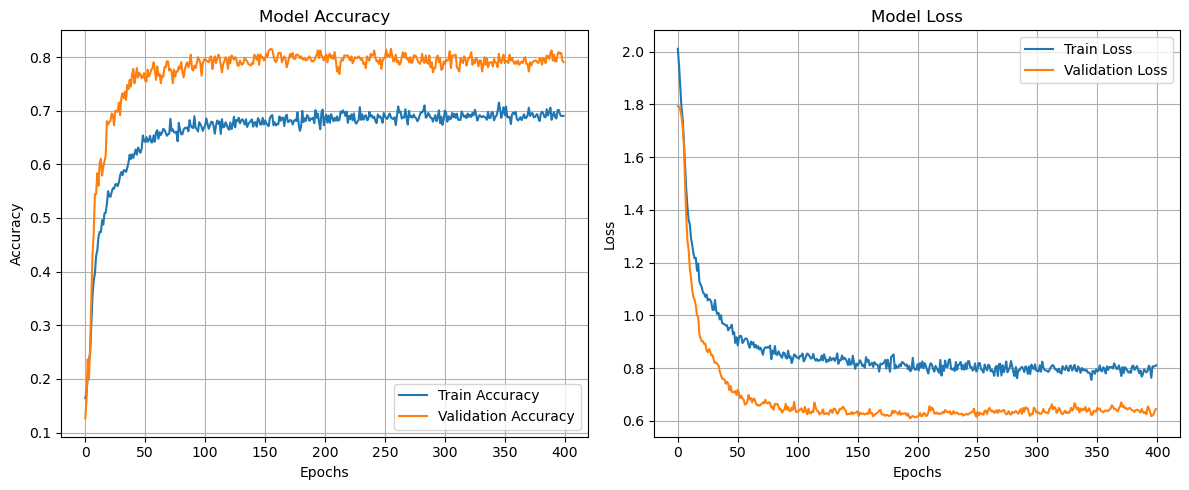

In [12]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(fittedModel.history['accuracy'], label='Train Accuracy')
plt.plot(fittedModel.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(fittedModel.history['loss'], label='Train Loss')
plt.plot(fittedModel.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
model.load_weights('/tmp/checkpoint.h5')
preds = model.predict(valid_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [16]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(np.argmax(valid_label, axis=1), np.argmax(preds, axis=1))

0.8015226784917244

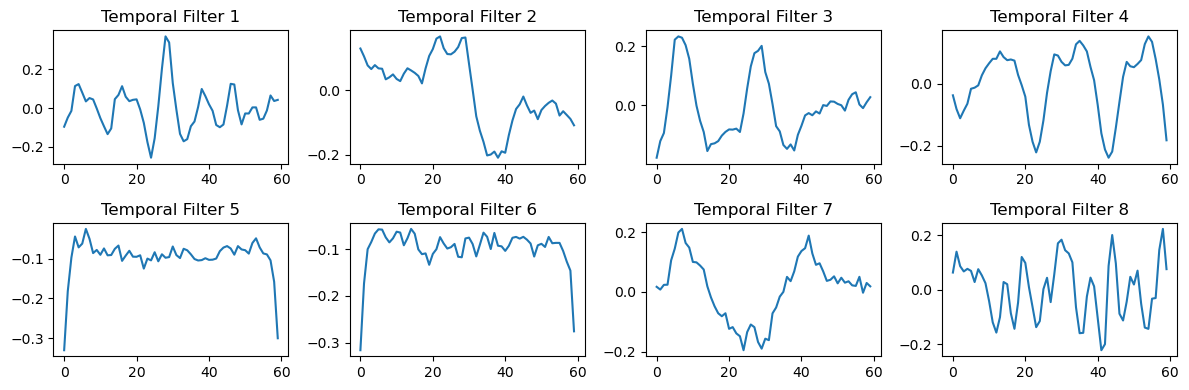

In [17]:
filters = np.squeeze(model.layers[2].get_weights())

fig = plt.subplots(2, 4, figsize=(12, 4))

for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.plot(filters[:, i-1])
    plt.title(f'Temporal Filter {i}')
    
plt.tight_layout()

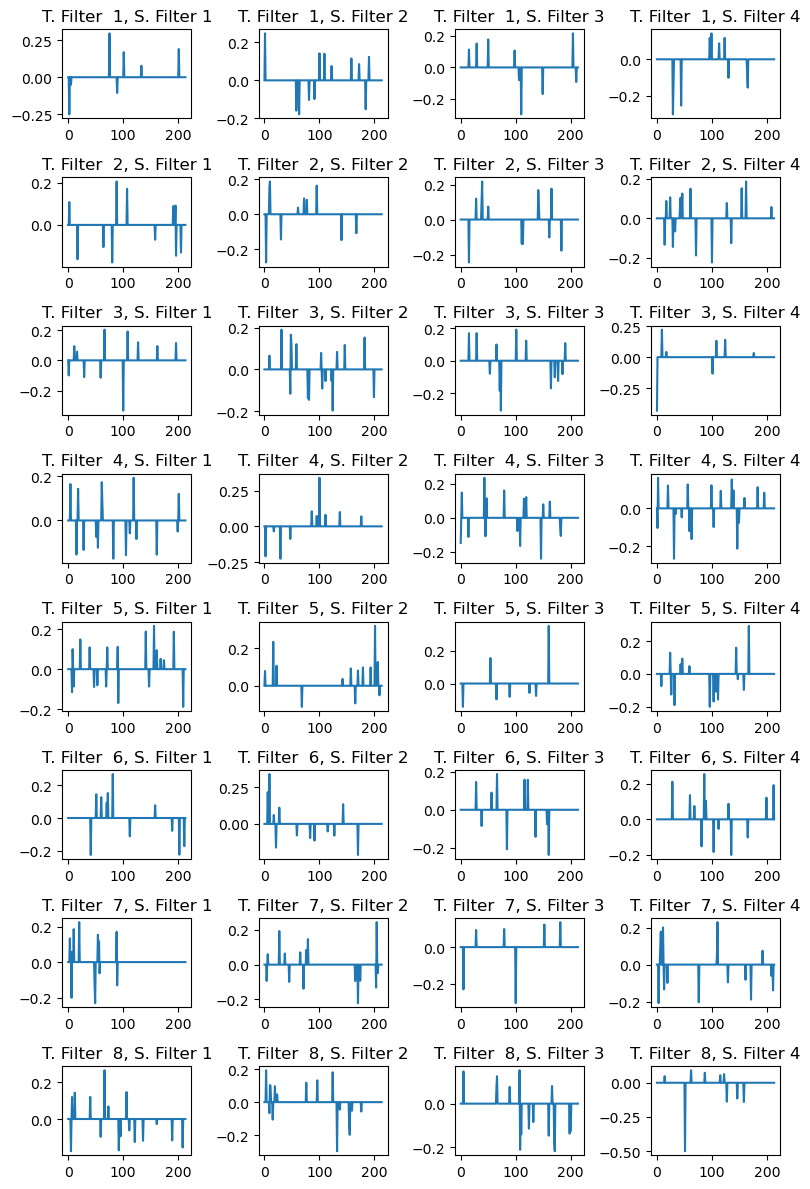

In [18]:
filters = np.squeeze(model.layers[4].get_weights())

fig = plt.subplots(8, 4, figsize=(8, 12))

i = 1
for j in range(8):
    for k in range(4):
        plt.subplot(8, 4, i)
        plt.plot(filters[:, j, k])
        plt.title(f'T. Filter  {j+1}, S. Filter {k+1}')
        i = i + 1
    
plt.tight_layout()